In [1]:
# classes with samples between 1.5k to 10k
#classes = ["Lysozyme_PF01183","Lysozyme_PF00182","Lysozyme_PF04965", "Lysozyme_PF00959","CHAP_PF05257", "SH34_PF06347"]
classes = ["CHAP_PF05257", "SH34_PF06347"]

In [2]:
%load_ext autoreload
%autoreload 
import sys
from pathlib import Path
ProjectRoot = Path().cwd().parent.parent
sys.path.append(str(ProjectRoot))

In [3]:
from src.data.modelData import ObjectDetection
! trash-put /home/satish27may/ProteinDomainDetection/data/PfamData/images_224/
! trash-put /home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/
data_handler = ObjectDetection(class_names=classes, img_dim=224)
data_handler.create_coco_data(augment_data=False, num_augs=1000, img_h=224, img_w=1000)

Fetching data from FASTA files for CHAP_PF05257
Fetching data from FASTA files for SH34_PF06347
number of seqs below 1000: 94
Dropped 123 number of duplicates based on sequences
Class distribution: 

PF05257    3425
PF06347    1648
Name: Class, dtype: int64
Genreating  images
Saving annotations


In [4]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


mkdir: cannot create directory ‘/home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset’: File exists
trash-put: cannot trash non existent '/home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/images_224'


100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

[11/25 13:11:02 d2.data.datasets.coco]: Loaded 3552 images in COCO format from /home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/train.json


{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/img_D0RQI1_9PROT_PF06347_SH3_4.png', 'height': 224, 'width': 1000, 'image_id': 5200, 'annotations': [{'iscrowd': 0, 'bbox': [25, 0, 56, 224], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


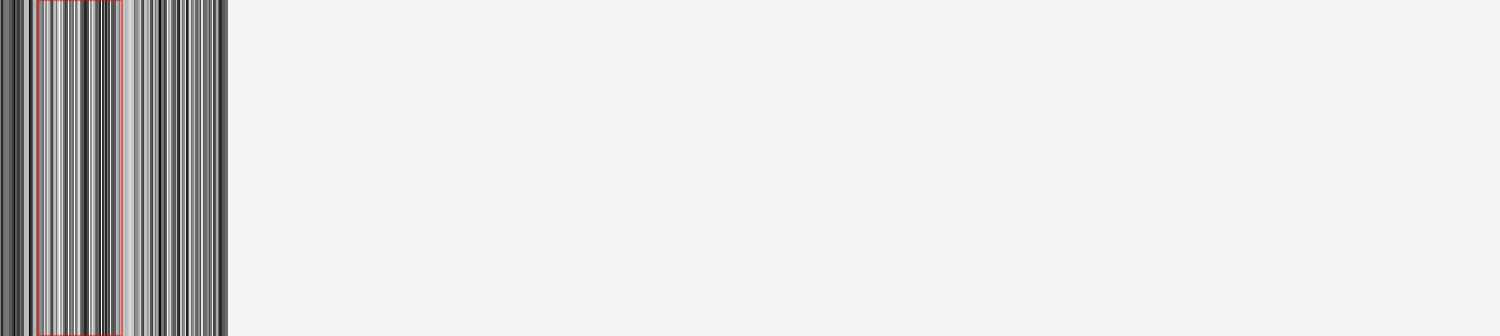

{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/img_A0A395NMJ3_TRIAR_PF05257_CHAP.png', 'height': 224, 'width': 1000, 'image_id': 2543, 'annotations': [{'iscrowd': 0, 'bbox': [119, 0, 90, 224], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


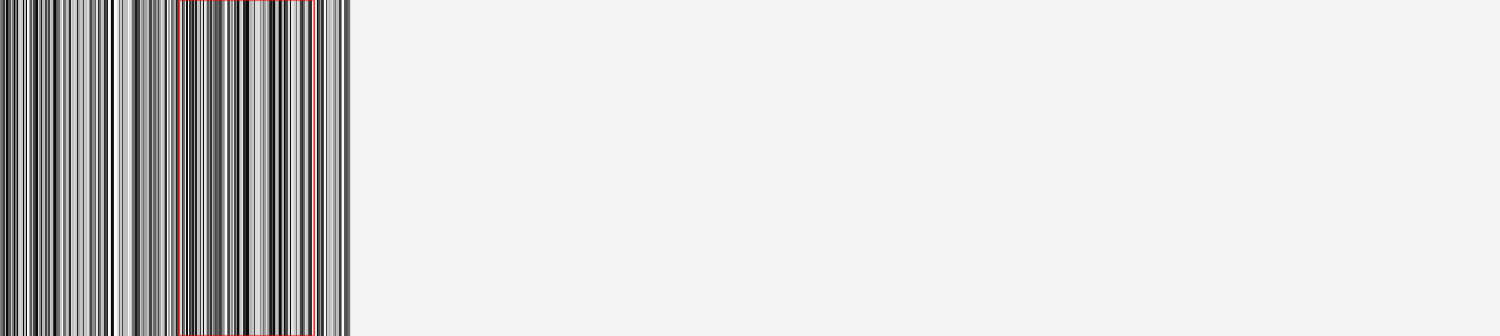

{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/img_A0A430AGL2_9ENTE_PF05257_CHAP.png', 'height': 224, 'width': 1000, 'image_id': 1085, 'annotations': [{'iscrowd': 0, 'bbox': [176, 0, 92, 224], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


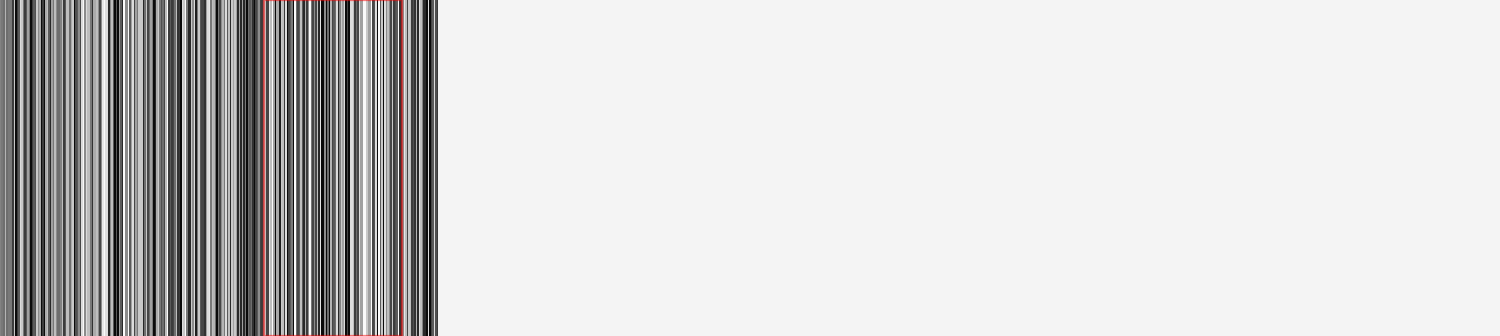

In [5]:
from detectron2.data.datasets import register_coco_instances
# images used should be at 224x1000 dim
register_coco_instances("ballon_train", {}, "/home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/train.json", "/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/")
register_coco_instances("ballon_val", {}, "/home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/val.json", "/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/")
# register_coco_instances("ballon_test", {}, "/home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224//test.json", "/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/")
balloon_metadata = MetadataCatalog.get("balloon_train")

! mkdir /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset
! trash-put /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/class1
! trash-put /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/images_224
! mkdir /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/class1
! cp  -r /home/satish27may/ProteinDomainDetection/data/PfamData/images_224/  /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/class1/
#! mv /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/images_224 /home/satish27may/DetectoRS_mmdetect/mmdetection/data/torch_dataset/class1
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


custom_dataset = datasets.ImageFolder('/home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset', transform=transforms.ToTensor())
custom_data_loader = DataLoader(dataset=custom_dataset,batch_size=128)
data_mean, data_std = get_mean_std(custom_data_loader)

data_mean = data_mean.numpy().tolist()
data_std = data_std.numpy().tolist()

dataset_dicts = DatasetCatalog.get("ballon_train")
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=1.5)
    bbox = d['annotations'][0]['bbox']
    out = visualizer.draw_box((bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]), edge_color='red', line_style='-')
    cv2_imshow(out.get_image()[:, :, ::-1])

In [9]:
! trash-put /home/satish27may/ProteinDomainDetection/models/*

In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
img_h, img_w = 224, 1000
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ballon_train",)
cfg.DATASETS.TEST = ("ballon_val",)
#cfg.MODEL.PIXEL_MEAN = data_mean
#cfg.MODEL.PIXEL_STD = data_std
cfg.INPUT.RANDOM_FLIP = "vertical"
cfg.TEST.DETECTIONS_PER_IMAGE = 100


cfg.TEST.AUG.FLIP = False
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3  # pick a good LR
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
#cfg.MODEL.RETINANET.IOU_THRESHOLDS = [0.4, 0.5]
cfg.SOLVER.MAX_ITER = 500 
cfg.MODEL.RETINANET.NUM_CLASSES = len(data_handler.class_names)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(data_handler.class_names)

cfg.OUTPUT_DIR = '/home/satish27may/ProteinDomainDetection/models'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[11/25 14:51:04 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (18, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.


[11/25 14:51:05 d2.engine.train_loop]: Starting training from iteration 0


/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/fvcore/transforms/transform.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  tensor = torch.from_numpy(np.ascontiguousarray(img))
/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/fvcore/transforms/transform.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writea

[11/25 14:51:19 d2.utils.events]:  eta: 0:05:36  iter: 19  total_loss: 0.6909  loss_cls: 0.5069  loss_box_reg: 0.1692  time: 0.7011  data_time: 0.0224  lr: 1.991e-05  max_mem: 2292M
[11/25 14:51:33 d2.utils.events]:  eta: 0:05:22  iter: 39  total_loss: 1.366  loss_cls: 1.044  loss_box_reg: 0.2928  time: 0.6998  data_time: 0.0050  lr: 3.9364e-05  max_mem: 2292M
[11/25 14:51:47 d2.utils.events]:  eta: 0:05:07  iter: 59  total_loss: 0.8596  loss_cls: 0.6254  loss_box_reg: 0.2612  time: 0.6984  data_time: 0.0047  lr: 5.7905e-05  max_mem: 2292M
[11/25 14:52:00 d2.utils.events]:  eta: 0:04:53  iter: 79  total_loss: 0.6292  loss_cls: 0.3864  loss_box_reg: 0.2306  time: 0.6973  data_time: 0.0050  lr: 7.5098e-05  max_mem: 2292M
[11/25 14:52:14 d2.utils.events]:  eta: 0:04:38  iter: 99  total_loss: 0.5621  loss_cls: 0.3626  loss_box_reg: 0.1852  time: 0.6966  data_time: 0.0049  lr: 9.0545e-05  max_mem: 2292M
[11/25 14:52:28 d2.utils.events]:  eta: 0:04:24  iter: 119  total_loss: 0.5617  loss_cls

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("ballon_val", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ballon_val")
print(trainer.test(cfg, trainer.model, evaluator))

[11/25 15:17:36 d2.data.datasets.coco]: Loaded 1521 images in COCO format from /home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/val.json
[11/25 15:17:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/25 15:17:36 d2.data.common]: Serializing 1521 elements to byte tensors and concatenating them all ...
[11/25 15:17:36 d2.data.common]: Serialized dataset takes 0.43 MiB
[11/25 15:17:36 d2.data.datasets.coco]: Loaded 1521 images in COCO format from /home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/val.json
[11/25 15:17:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/25 15:17:36 d2.data.common]: Serializing 1521 elements to byte tensors and concatenating them all ...
[11/25 15:17:36 d2.data.common]: Serialized d

In [ ]:
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
COCOeval_opt.accumulate() finished in 0.09 seconds.
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.502
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.353
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.323
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.418
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.716
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.726
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.727
[11/23 15:01:16 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:------:|:------:|:------:|:-----:|:-----:|:------:|
| 32.324 | 50.211 | 35.325 |  nan  | 0.000 | 32.349 |
[11/23 15:01:16 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/23 15:01:16 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|
| PF05257    | 41.624 | PF06347    | 23.025 |




COCOeval_opt.accumulate() finished in 0.62 seconds.
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.343
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.450
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.383
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.201
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.581
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.730
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.733
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.733
[11/23 10:26:47 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:------:|:------:|:------:|:-----:|:------:|:------:|
| 34.336 | 45.023 | 38.327 |  nan  | 20.099 | 34.352 |
[11/23 10:26:47 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/23 10:26:47 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| PF01183    | 54.320 | PF05257    | 11.621 | PF00959    | 28.577 |
| PF00182    | 35.231 | PF04965    | 70.866 | PF06347    | 5.398  |